In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.__version__

'1.12.1+cu102'

# PyTorch workflow
<img src="img/01_a_pytorch_workflow.png" width="1100"/>

# 1. Data Preparing
In machine learning data can be almost anything you can imagine

Machine learning is a game of two parts:
1. Turn you data into numbers
2. Pick or build a model to learn the representation as best as possible

In [2]:
# now we create our data (it will be simple linear regression problem)

weight = 0.73221
bias = 0.36
start = 0
end = 3
step = 0.05

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias
print('Shape of X tensor is {} and y is {}'.format(X.shape, y.shape))

X[:5], y[:5]

Shape of X tensor is torch.Size([60, 1]) and y is torch.Size([60, 1])


(tensor([[0.0000],
         [0.0500],
         [0.1000],
         [0.1500],
         [0.2000]]),
 tensor([[0.3600],
         [0.3966],
         [0.4332],
         [0.4698],
         [0.5064]]))

We want to learn the relationship between `X` and `y`

In [3]:
train_split = int(0.8 * len(X))  ## 80% of our data will be used for training

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print('{} objects will be used for training and {} for testing'.format(len(X_train), len(X_test)))

48 objects will be used for training and 12 for testing


In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(17, 7))
    plt.scatter(train_data, train_labels, c='b', s=11, label='train')
    plt.scatter(test_data, test_labels, c='g', s=11, label='test')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', marker='*', s=15, label='predictions')
    plt.legend(prop={'size':12})

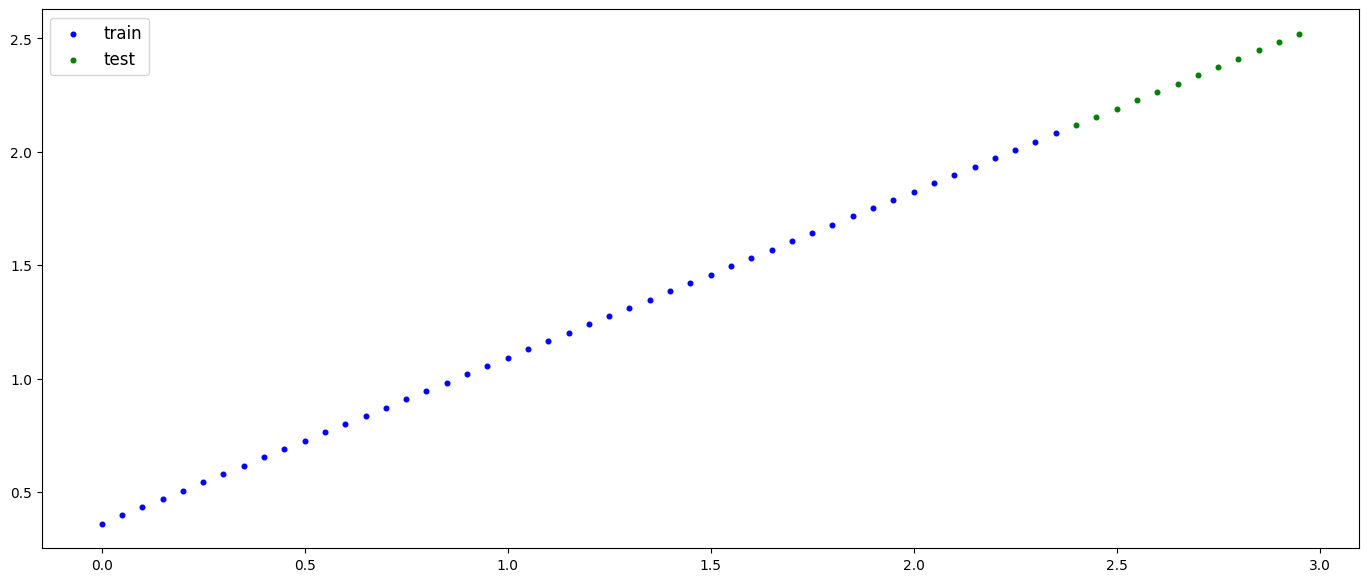

In [5]:
plot_predictions()

# 2. Build model

In [6]:
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(size=(1,),
                                              dtype=torch.float32,
                                              requires_grad=True))
        self.bias = nn.Parameter(torch.rand(size=(1,),
                                            dtype=torch.float32,
                                            requires_grad=True))
    def forward(self, input_object):
        # all subclasses of nn.Module require this method
        # to define the computation that will take place
        # on the data passed to model
        return self.weight * input_object + self.bias

PyTorch use 4 essential modules for any kind of neural network:
* `torch.nn` - all blocks for computational graphs
* `torch.optim` - various optimization algorithms (change model parameters stored in `nn.Parameter`)
* `torch.utils.data.Dataset` -
* `torch.utils.data.Dataloader` -

In [7]:
model_0 = SimpleLinearModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

we can see predictive power of our model by using *inference mode*. It turns off a bunch of things (gradient tracking, dropout, ...) to make **forwrad-passes** faster and safely

In [9]:
tmp_loss = nn.L1Loss()
with torch.inference_mode():
    y_predicted = model_0(X_test)
    print('MAE is', tmp_loss(y_predicted, y_test).item())

# it is the same as torch.no_grad(), but new version ^-^

MAE is 0.9564126133918762


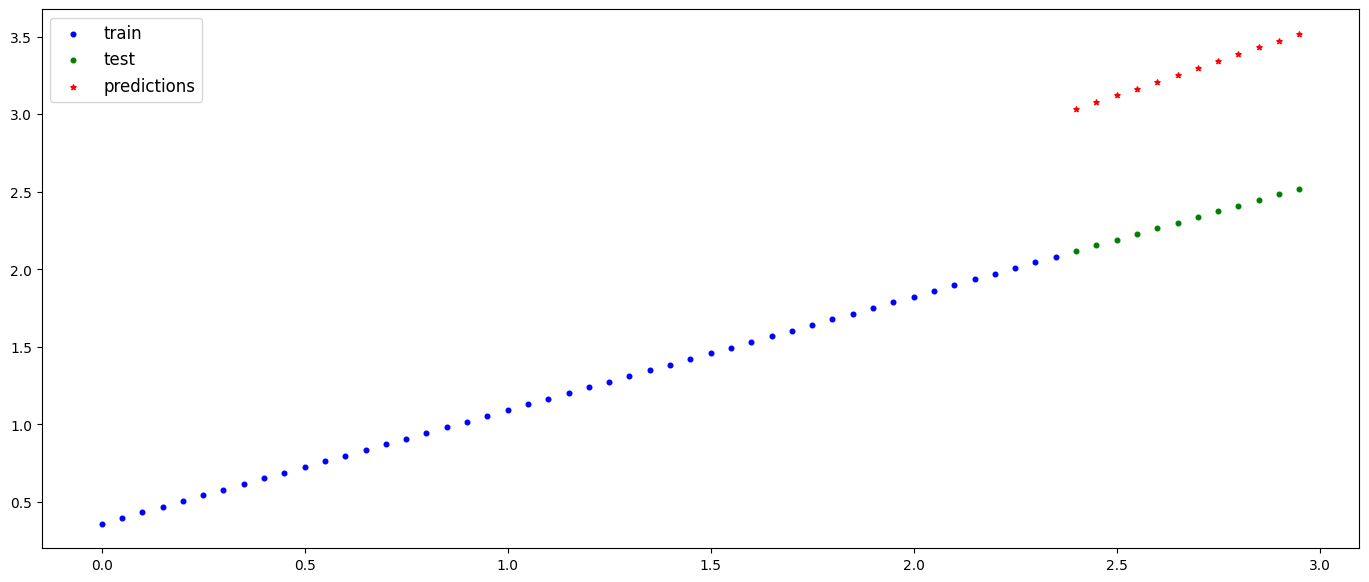

In [10]:
plot_predictions(predictions=y_predicted)

# 3. Train model
It is fun to write code and see if the model can try and figure them out itself

In [11]:
# create loss and optimizer

# loss measures how wrong your models predictions
loss_fn = nn.L1Loss()

# optimizer tells model how to update parameters to make it better
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.05)

**Optimizer** and **loss function** depend on what kind of problem you're working on.

`lr` - **Learning rate** is the hyperparameter (it is set by engineer). Common values are `0.01`, `0.001`, `0.0001`, but these can also be adjusted over time (with help of **lr scheduling**)


*loop* because we want our model to look at each sample in dataset

**Steps (training loop):**
1) forward pass
2) calculate the loss
3) zero gradients
4) backpropagation
5) optimizer update model parameters

In [12]:
def train_loop(data=X_train,
               labels=y_train,
               model=model_0,
               optim=optimizer,
               loss=loss_fn):
    # train is default state of a model
    model.train()

    # forward pass
    y_pred = model(data)

    # calculate the loss
    loss_value = loss(y_pred, labels)

    # zero gradients
    optim.zero_grad()

    # backpropagation
    loss_value.backward()

    # optimizer update models parameters
    optim.step()

    return loss_value.detach().numpy()

**Steps (testing loop):**
1) forward pass
2) calculate the loss
3) evaluate model using metric

In [13]:
def test_loop(data=X_test,
              labels=y_test,
              model=model_0,
              loss=loss_fn,
              metric=None):
    model.eval()
    with torch.inference_mode():
        # forward pass
        y_pred = model(data)

        # calculate the loss
        loss_value = loss(y_pred, labels)

        print(f'loss value on the test - {loss_value.detach().numpy()}')
        # metric evaluation
        if metric is not None:
            m = metric(labels, y_pred)
            print(f'metric on the test - {m}')
        return loss_value.detach().numpy()

In [14]:
epochs = 15
loss_train = []
loss_test = []
for e in range(1, epochs+1):
    print(f'Epoch {e}/{epochs}')
    loss_train.append(train_loop())
    loss_test.append(test_loop())

Epoch 1/15
loss value on the test - 0.9196626543998718
Epoch 2/15
loss value on the test - 0.8829126954078674
Epoch 3/15
loss value on the test - 0.8461627960205078
Epoch 4/15
loss value on the test - 0.8094127178192139
Epoch 5/15
loss value on the test - 0.7726628184318542
Epoch 6/15
loss value on the test - 0.7359127998352051
Epoch 7/15
loss value on the test - 0.6991627812385559
Epoch 8/15
loss value on the test - 0.6624129414558411
Epoch 9/15
loss value on the test - 0.6256629824638367
Epoch 10/15
loss value on the test - 0.5889129638671875
Epoch 11/15
loss value on the test - 0.5521629452705383
Epoch 12/15
loss value on the test - 0.5154131054878235
Epoch 13/15
loss value on the test - 0.47866299748420715
Epoch 14/15
loss value on the test - 0.44191309809684753
Epoch 15/15
loss value on the test - 0.40516313910484314


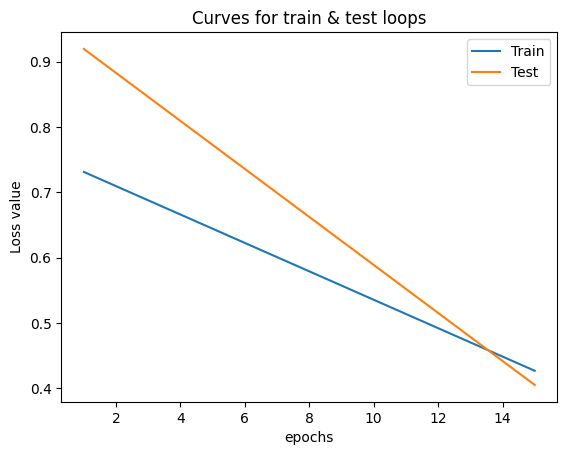

In [15]:
plt.plot(np.arange(1, epochs+1), loss_train, label='Train')
plt.plot(np.arange(1, epochs+1), loss_test, label='Test')
plt.title('Curves for train & test loops')
plt.xlabel('epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

In [16]:
print(f'the model parameters after learning: {model_0.state_dict()}')
print(f'original parameters: weight = {weight} and bias = {bias}')

the model parameters after learning: OrderedDict([('weight', tensor([0.7323])), ('bias', tensor([0.7650]))])
original parameters: weight = 0.73221 and bias = 0.36


# 4. Making predictions with a trained model (inference)
things to remember (when making predictions):
1) set the model in the evaluation mode (`model.eval()`)
2) context manager (`with torch.inference_mode():`)
3) data and model on the same device (on GPU or on CPU)

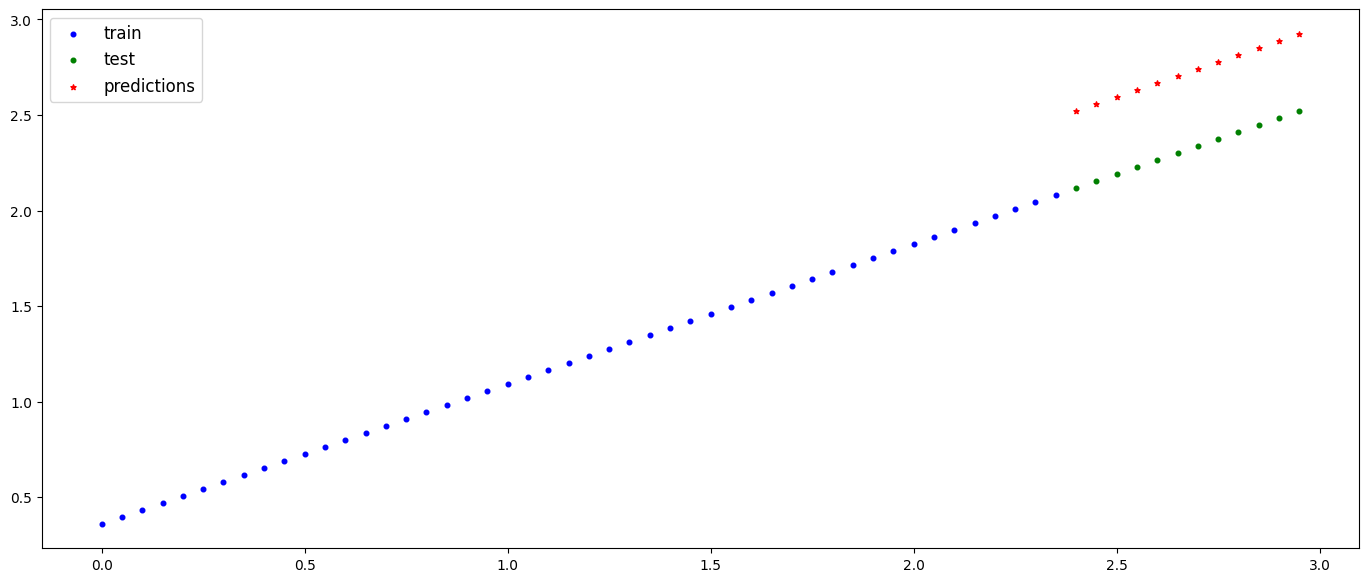

In [18]:
model_0.eval()
with torch.inference_mode():
    predictions = model_0(X_test)

plot_predictions(predictions=predictions)

# 5. Saving and loading a PyTorch model
* `torch.save` = save a serialized object to disk using python **pickle** utility
* `torch.load` = use pickle's features to deserialize and load object files (models, tensors, dictionaries) into memory
* `torch.load_state_dict` = loads a model's parameter dictionary (`model.state_dict()`)

**!!!** the `pickle` module is not secure, so you should unpickle data that you trust

In [19]:
from pathlib import Path

# 1. Directories for models
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = 'model_workflow_tutorial.pth'
model_save = model_path / model_name

print(f'Save model into {model_save}')
torch.save(obj=model_0.state_dict(),
           f=model_save)

Save model into models/model_workflow_tutorial.pth


In [24]:
ls -l models/model_workflow_tutorial.pth

-rw-r--r--. 1 ffrankusha ffrankusha 1063 Oct 31 16:30 models/model_workflow_tutorial.pth


In [27]:
# load model
dict_with_params = torch.load(f="./models/model_workflow_tutorial.pth")
dict_with_params

OrderedDict([('weight', tensor([0.7323])), ('bias', tensor([0.7650]))])

In [28]:
new_model = SimpleLinearModel()
new_model.load_state_dict(dict_with_params)

<All keys matched successfully>

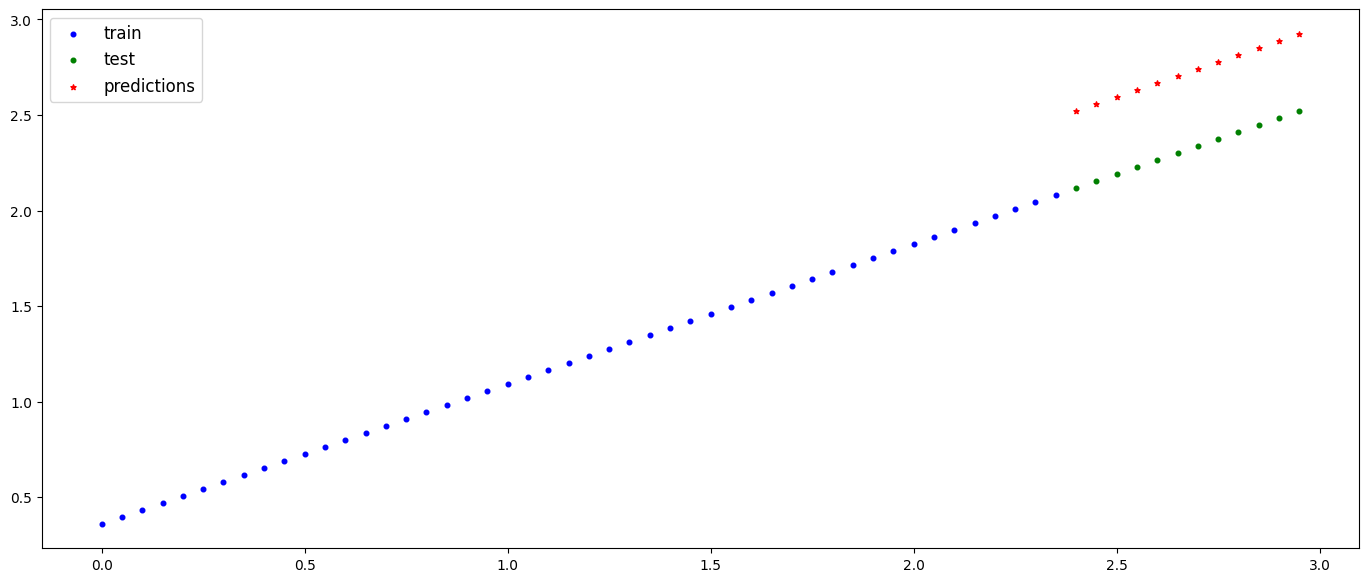

In [29]:
new_model.eval()
with torch.inference_mode():
    new_predictions = new_model(X_test)

plot_predictions(predictions=new_predictions)

# 6. Putting it together

In [43]:
weight = -4.95
bias = +1.113

X = (torch.arange(0.0, 10, 0.1)).unsqueeze(dim=1)
y = X * weight + bias

train_len = int(0.8 * len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]

print(f'Points in the train set: {len(X_train)}')
print(f'Points in the test set: {len(X_test)}')
X_train.shape

Points in the train set: 80
Points in the test set: 20


torch.Size([80, 1])

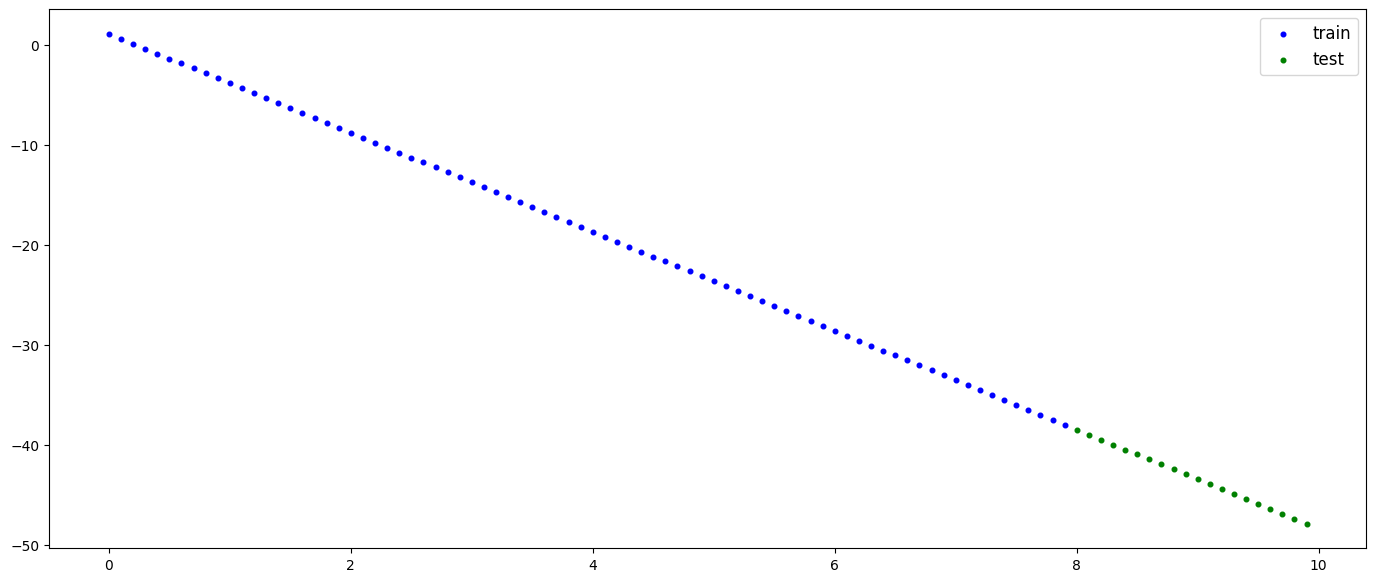

In [44]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

In [45]:
model_1 = SimpleLinearModel()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.001)

In [46]:
epochs = 1500
device = 'cuda:0' if torch.cuda.is_available() else "cpu"

model_1.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

loss_values_train = []
loss_values_test = []

for e in range(1, epochs+1):
    # train
    model_1.train()
    y_pred = model_1(X_train)
    loss_train = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    loss_values_train.append(loss_train.detach().numpy())

    # inference
    model_1.eval()
    with torch.inference_mode():
        y_pred = model_1(X_test)
        loss_test = loss_fn(y_pred, y_test)
    loss_values_test.append(loss_test.detach().numpy())

    if e % 100 == 0:
        print(f'epoch {e}/{epochs} --- ')
        print(f'loss (on the test) is {loss_test.item()}')

epoch 100/1500 --- 
loss (on the test) is 1.9687530994415283
epoch 200/1500 --- 
loss (on the test) is 0.6890925168991089
epoch 300/1500 --- 
loss (on the test) is 0.6151190400123596
epoch 400/1500 --- 
loss (on the test) is 0.5573930740356445
epoch 500/1500 --- 
loss (on the test) is 0.5051701664924622
epoch 600/1500 --- 
loss (on the test) is 0.4578437805175781
epoch 700/1500 --- 
loss (on the test) is 0.41495341062545776
epoch 800/1500 --- 
loss (on the test) is 0.37607818841934204
epoch 900/1500 --- 
loss (on the test) is 0.3408460021018982
epoch 1000/1500 --- 
loss (on the test) is 0.30891069769859314
epoch 1100/1500 --- 
loss (on the test) is 0.2799747586250305
epoch 1200/1500 --- 
loss (on the test) is 0.2537449598312378
epoch 1300/1500 --- 
loss (on the test) is 0.22997240722179413
epoch 1400/1500 --- 
loss (on the test) is 0.20842841267585754
epoch 1500/1500 --- 
loss (on the test) is 0.1889030635356903


In [74]:
path = Path('./models')
path.mkdir(parents=True, exist_ok=True)
name = 'second_workflow_model.pth'
path = path / name

torch.save(obj=model_1.state_dict(),
           f=path)

In [69]:
ls -l models/second_workflow_model.pth

-rw-r--r--. 1 ffrankusha ffrankusha 1511 Oct 31 17:26 models/second_workflow_model.pth


In [75]:
new_second_model = SimpleLinearModel()
new_second_model.load_state_dict(torch.load(path))
new_second_model.to(device)

new_second_model.eval()
with torch.inference_mode():
    predictions = new_second_model(X_test)

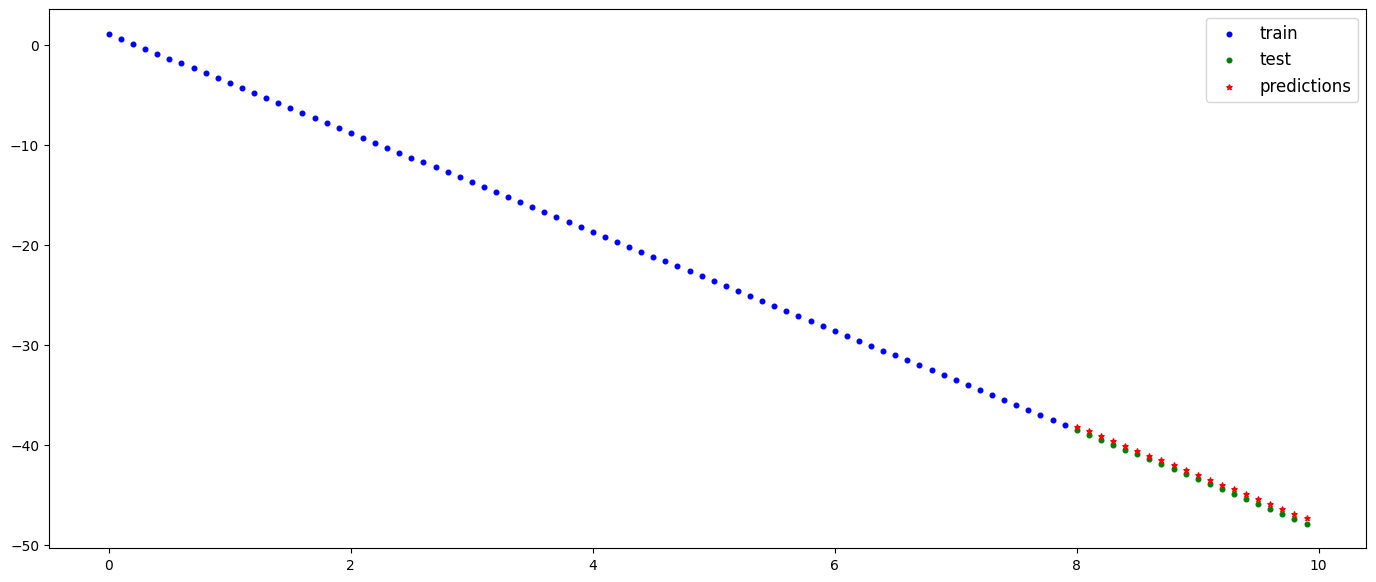

In [76]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=predictions)

# 7. Exercises

In [20]:
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

1. Create a straight line dataset using the linear regression formula (weight * X + bias).
Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
Split the data into 80% training, 20% testing.
Plot the training and testing data so it becomes visual.

80 points in train set and 20 points in test


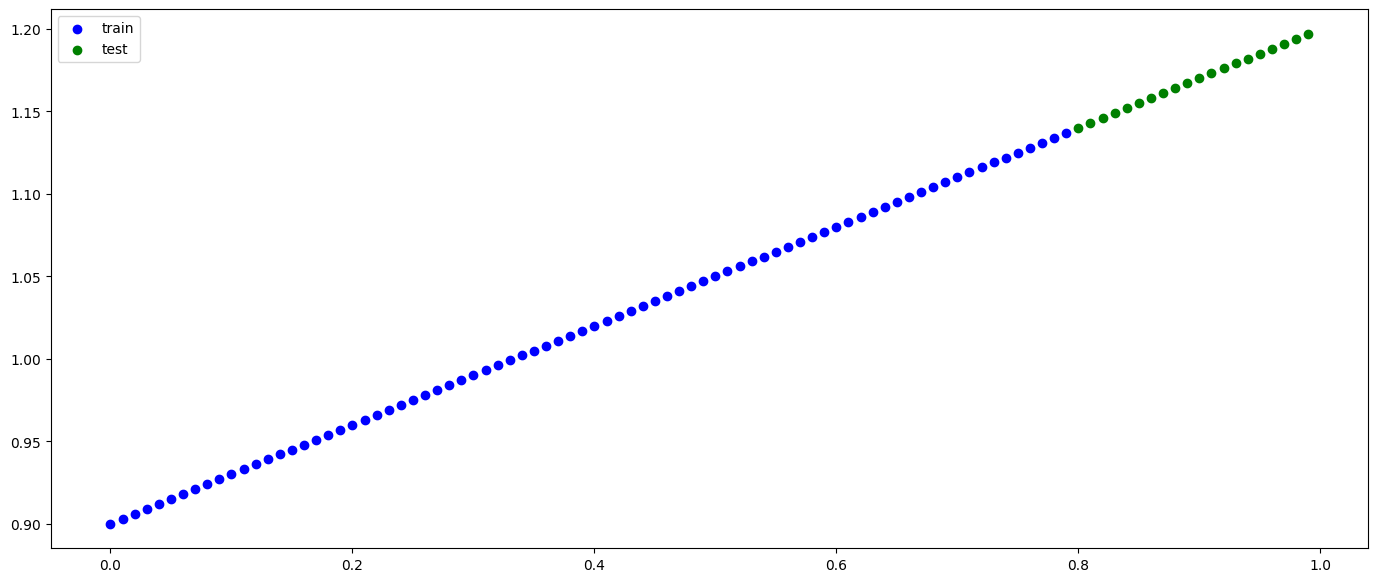

In [21]:
weight = 0.3
bias = 0.9
X = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y = weight * X + bias

X = X.to(device)
y = y.to(device)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f'{len(X_train)} points in train set and {X_test.shape[0]} points in test')

plt.figure(figsize=(17, 7))
plt.scatter(X_train, y_train, c='b', label='train')
plt.scatter(X_test, y_test, c='g', label='test')
plt.legend()
plt.show()

2. Build a PyTorch model by subclassing nn.Module.
Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
Once you've constructed the model, make an instance of it and check its state_dict().
Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [30]:
class ExerciseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(
            torch.randn(1, dtype=torch.float32, requires_grad=True)
        )
        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float32, requires_grad=True)
        )
    def forward(self, data):
        return self.weight * data + self.bias

model = ExerciseModel().to(device=device)
model.state_dict()

OrderedDict([('weight', tensor([-1.0845])), ('bias', tensor([-1.3986]))])

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
Write a training loop to perform the appropriate training steps for 300 epochs.
The training loop should test the model on the test dataset every 20 epochs.

In [31]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [32]:
epochs = 300
for epoch in range(1, epochs+1):
    model.train()
    # forward pass
    y_predicted = model(X_train)

    # loss calculation
    loss = loss_fn(y_predicted, y_train)

    # zero optimizer
    optimizer.zero_grad()

    # backpropagation algorithm
    loss.backward()

    # update parameters
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.inference_mode():
            predictions = model(X_test)
            loss_test = loss_fn(predictions, y_test)
            print(f'epoch {epoch}/{epochs}: loss = {loss_test.item()} (test)')

epoch 20/300: loss = 3.267037868499756 (test)
epoch 40/300: loss = 2.996333122253418 (test)
epoch 60/300: loss = 2.72562837600708 (test)
epoch 80/300: loss = 2.454923629760742 (test)
epoch 100/300: loss = 2.1842188835144043 (test)
epoch 120/300: loss = 1.9135141372680664 (test)
epoch 140/300: loss = 1.6428089141845703 (test)
epoch 160/300: loss = 1.3721040487289429 (test)
epoch 180/300: loss = 1.1013990640640259 (test)
epoch 200/300: loss = 0.830694317817688 (test)
epoch 220/300: loss = 0.5599895119667053 (test)
epoch 240/300: loss = 0.3136824071407318 (test)
epoch 260/300: loss = 0.20332419872283936 (test)
epoch 280/300: loss = 0.16352637112140656 (test)
epoch 300/300: loss = 0.14375805854797363 (test)


4. Make predictions with the trained model on the test data.
Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

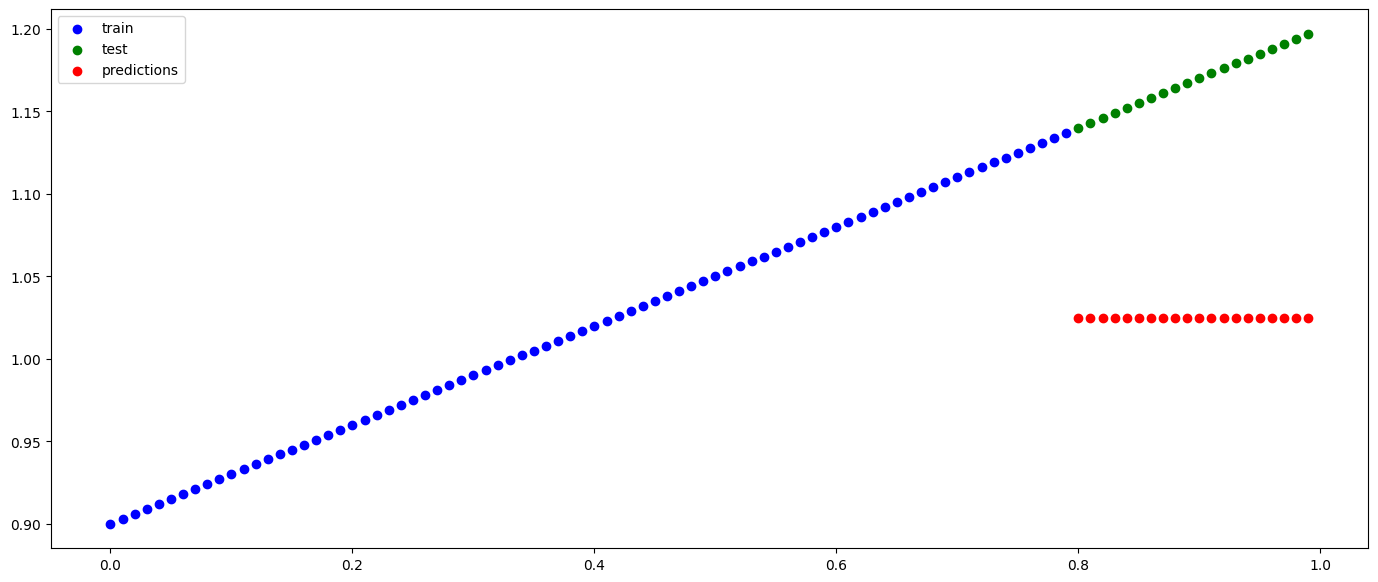

In [33]:
model.eval()
with torch.inference_mode():
    predictions = model(X_test)

plt.figure(figsize=(17, 7))
plt.scatter(X_train, y_train, c='b', label='train')
plt.scatter(X_test, y_test, c='g', label='test')
plt.scatter(X_test, predictions, c='r', label='predictions')
plt.legend()
plt.show()

5. Save your trained model's state_dict() to file.
Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [36]:
from pathlib import Path

path = Path('models')
path = path / 'exercises_model_workflow.pth'

torch.save(obj=model.state_dict(),
           f=path)

In [40]:
new_exercise_model = ExerciseModel().to(device=device)
new_exercise_model.load_state_dict(torch.load(f=path))

<All keys matched successfully>

In [41]:
new_exercise_model.eval()
with torch.inference_mode():
    predictions_new_model = new_exercise_model(X_test)
predictions_new_model == predictions

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])